In [2]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import keras

2025-10-31 09:14:35.593485: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-31 09:14:35.982322: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-31 09:14:42.392950: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
# Paths
train_dir = "../Data/train"
test_dir = "../Data/test"
classes = ["Abnormal_Heartbeat", "Myocardial_Infarction", "History_Myocardial_Infarction", "Normal"]

In [4]:
# Image dimensions
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 8  # small batch due to large images

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.05,
    validation_split=0.15
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # important for correct label ordering
)

Found 2572 images belonging to 4 classes.
Found 451 images belonging to 4 classes.
Found 928 images belonging to 4 classes.


In [5]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Stage 1: Feature extraction
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(len(classes), activation='softmax')(x)

I0000 00:00:1761916495.501429 3813520 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1506 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:1b:00.0, compute capability: 7.5
I0000 00:00:1761916495.503270 3813520 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22804 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:1c:00.0, compute capability: 7.5
I0000 00:00:1761916495.505274 3813520 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22802 MB memory:  -> device: 2, name: Quadro RTX 6000, pci bus id: 0000:1d:00.0, compute capability: 7.5
I0000 00:00:1761916495.507113 3813520 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 22802 MB memory:  -> device: 3, name: Quadro RTX 6000, pci bus id: 0000:1e:00.0, compute capability: 7.5
I0000 00:00:1761916495.508489 3813520 gpu_device.cc:2020] Created device /job:localhost/r

In [6]:
model = Model(inputs=base_model.input, outputs=predictions)

# Compile
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

checkpoint = ModelCheckpoint(
    "mobilenetv2_best_stage1.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=5,
    verbose=1,
    min_lr=1e-6
)

print("\n🔹 Training Stage 1: Feature Extraction...")
history_stage1 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=50,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[early_stop, checkpoint, lr_reduction]
)


🔹 Training Stage 1: Feature Extraction...


/home/calviem/CSSE416/Homework/env/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


2025-10-31 09:15:51.571703: I external/local_xla/xla/service/service.cc:163] XLA service 0x7f4fa40033b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-31 09:15:51.571737: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Quadro RTX 6000, Compute Capability 7.5
2025-10-31 09:15:51.571744: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (1): Quadro RTX 6000, Compute Capability 7.5
2025-10-31 09:15:51.571748: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (2): Quadro RTX 6000, Compute Capability 7.5
2025-10-31 09:15:51.571753: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (3): Quadro RTX 6000, Compute Capability 7.5
2025-10-31 09:15:51.571757: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (4): Quadro RTX 6000, Compute Capability 7.5
2025-10-31 09:15:51.571761: I external/local_xla/xla/service/service.cc:171]  

  1/322 ━━━━━━━━━━━━━━━━━━━━ 1:45:25 20s/step - accuracy: 0.2500 - loss: 1.6395

I0000 00:00:1761916565.862157 3817295 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


302/322 ━━━━━━━━━━━━━━━━━━━━ 6s 310ms/step - accuracy: 0.4403 - loss: 1.2481

2025-10-31 09:17:41.611430: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-31 09:17:41.746791: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-31 09:17:41.883841: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-31 09:17:42.019749: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-31 09:17:47.897399: E external/local_xla/xla/stream_

322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.4443 - loss: 1.2410

2025-10-31 09:18:20.916062: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-31 09:18:21.051752: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-31 09:18:21.186319: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-31 09:18:27.556582: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-10-31 09:18:27.688530: E external/local_xla/xla/stream_


Epoch 1: val_loss improved from None to 0.99348, saving model to mobilenetv2_best_stage1.keras
322/322 ━━━━━━━━━━━━━━━━━━━━ 165s 453ms/step - accuracy: 0.5074 - loss: 1.1309 - val_accuracy: 0.5698 - val_loss: 0.9935 - learning_rate: 0.0010
Epoch 2/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.5902 - loss: 0.9609
Epoch 2: val_loss improved from 0.99348 to 0.85780, saving model to mobilenetv2_best_stage1.keras
322/322 ━━━━━━━━━━━━━━━━━━━━ 109s 338ms/step - accuracy: 0.6104 - loss: 0.9311 - val_accuracy: 0.6652 - val_loss: 0.8578 - learning_rate: 0.0010
Epoch 3/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.6393 - loss: 0.8623
Epoch 3: val_loss improved from 0.85780 to 0.78843, saving model to mobilenetv2_best_stage1.keras
322/322 ━━━━━━━━━━━━━━━━━━━━ 110s 341ms/step - accuracy: 0.6392 - loss: 0.8762 - val_accuracy: 0.7317 - val_loss: 0.7884 - learning_rate: 0.0010
Epoch 4/50
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.6786 - loss: 0.7922
Epoch 4: 

In [9]:
for layer in base_model.layers[:100]:
    layer.trainable = False
for layer in base_model.layers[100:]:
    layer.trainable = True

# Recompile with a smaller learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

checkpoint_fine = ModelCheckpoint(
    "mobilenetv2_best_finetuned.keras",
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

print("\n🔹 Training Stage 2: Fine-Tuning...")
history_stage2 = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    steps_per_epoch=len(train_generator),
    validation_steps=len(validation_generator),
    callbacks=[early_stop, checkpoint_fine, lr_reduction]
)


🔹 Training Stage 2: Fine-Tuning...
Epoch 1/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.3356 - loss: 12.0700
Epoch 1: val_loss improved from None to 1.90016, saving model to mobilenetv2_best_finetuned.keras
322/322 ━━━━━━━━━━━━━━━━━━━━ 170s 443ms/step - accuracy: 0.3966 - loss: 8.6920 - val_accuracy: 0.5299 - val_loss: 1.9002 - learning_rate: 1.0000e-05
Epoch 2/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.5236 - loss: 4.0108
Epoch 2: val_loss did not improve from 1.90016
322/322 ━━━━━━━━━━━━━━━━━━━━ 115s 357ms/step - accuracy: 0.5365 - loss: 3.6931 - val_accuracy: 0.4080 - val_loss: 4.2130 - learning_rate: 1.0000e-05
Epoch 3/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.5849 - loss: 2.6182
Epoch 3: val_loss did not improve from 1.90016
322/322 ━━━━━━━━━━━━━━━━━━━━ 114s 355ms/step - accuracy: 0.5863 - loss: 2.4590 - val_accuracy: 0.4124 - val_loss: 5.2171 - learning_rate: 1.0000e-05
Epoch 4/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accu

KeyboardInterrupt: 

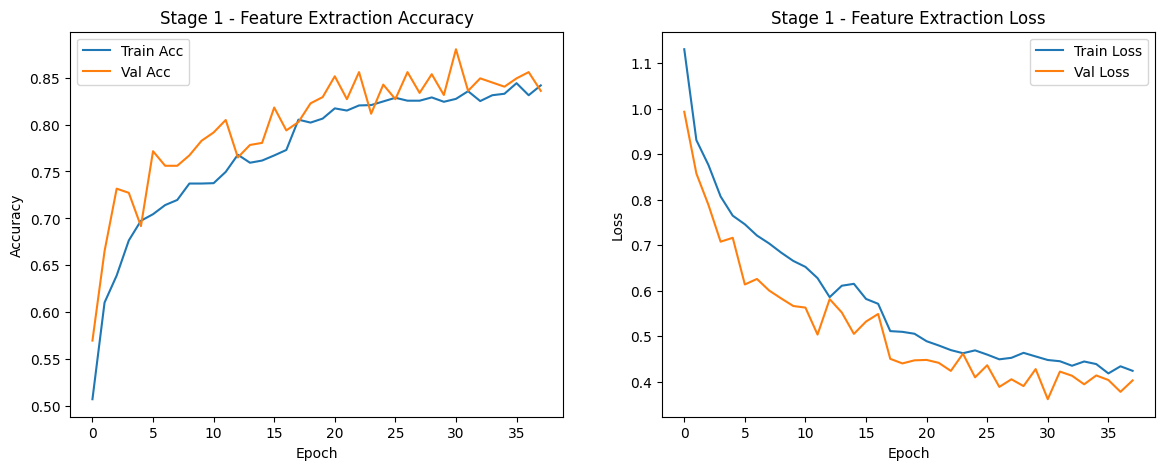

In [ ]:
def plot_history(hist, title):
    plt.figure(figsize=(14,5))
    plt.subplot(1,2,1)
    plt.plot(hist.history['accuracy'], label='Train Acc')
    plt.plot(hist.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(hist.history['loss'], label='Train Loss')
    plt.plot(hist.history['val_loss'], label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history_stage1, "Stage 1 - Feature Extraction")
plot_history(history_stage2, "Stage 2 - Fine-Tuning")


In [10]:
print("\n🔹 Evaluating on Test Set...")
model = keras.models.load_model("mobilenetv2_best_stage1.keras")
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"✅ Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")


🔹 Evaluating on Test Set...
116/116 ━━━━━━━━━━━━━━━━━━━━ 34s 239ms/step - accuracy: 0.7726 - loss: 0.5941
✅ Test Accuracy: 0.7726 | Test Loss: 0.5941


116/116 ━━━━━━━━━━━━━━━━━━━━ 29s 214ms/step


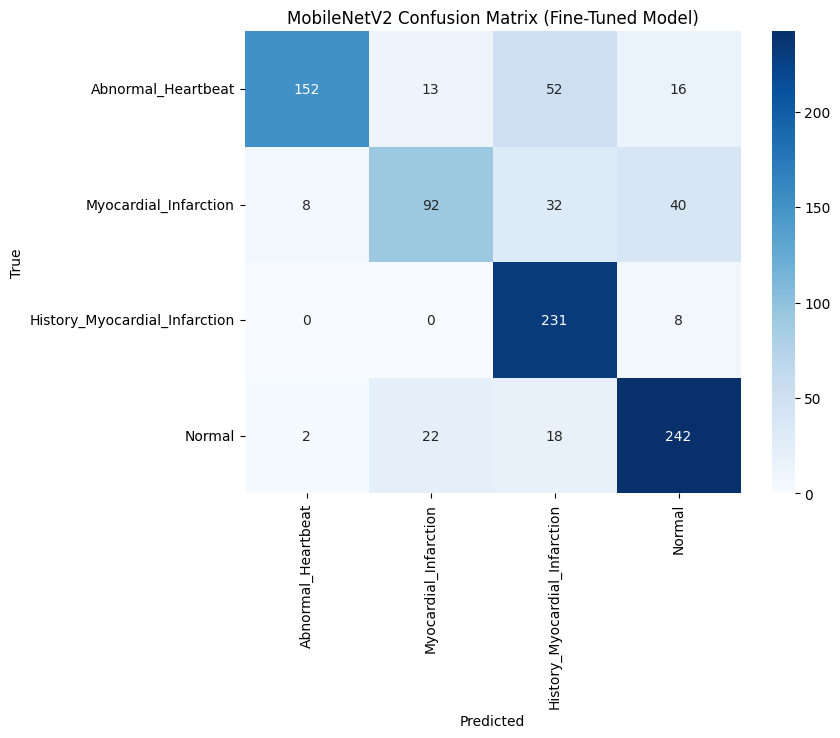

In [11]:
preds = model.predict(test_generator, steps=len(test_generator), verbose=1)
pred_labels = np.argmax(preds, axis=1)
true_labels = test_generator.classes

# Confusion matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("MobileNetV2 Confusion Matrix (Fine-Tuned Model)")
plt.show()

In [12]:
report = classification_report(true_labels, pred_labels, target_names=classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report)

,precision,recall,f1-score,support
Abnormal_Heartbeat,0.938272,0.652361,0.769620,233.000000
Myocardial_Infarction,0.724409,0.534884,0.615385,172.000000
History_Myocardial_Infarction,0.693694,0.966527,0.807692,239.000000
Normal,0.790850,0.852113,0.820339,284.000000
accuracy,0.772629,0.772629,0.772629,0.772629
macro avg,0.786806,0.751471,0.753259,928.000000
weighted avg,0.790528,0.772629,0.766360,928.000000
